In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Import Libraries

In [80]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
wordnet_lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

import string
import torch
import pickle
from heapq import nlargest
import sys
import spacy
# !pip install truecase
import truecase
from spacy import displacy
from collections import Counter
from nltk.tag import StanfordNERTagger
import en_core_web_sm
nlp = en_core_web_sm.load()
from pprint import pprint
# !pip install unidecode
from unidecode import unidecode
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel, euclidean_distances
import warnings
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.spatial import distance
import numpy as np
import re
# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.cluster.util import cosine_distance
import tensorflow as tf
import transformers
# !pip install sent2vec
from sent2vec.vectorizer import Vectorizer as S2vectorizer
tqdm_notebook.pandas()
warnings.filterwarnings("ignore")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
import networkx as nx

#import pipelines
from transformers import pipeline
nlp2 = pipeline("question-answering")

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_columns', 0)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Preprocessing

In [69]:
stop_words = stopwords.words("english")

def clean_normalcase_stop_lem(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    text = ' '.join([wordnet_lemmatizer.lemmatize(i) for i in text.split()])
    return text

def clean_normalcase_nostop_lem(text):
    text = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    return text

def clean_lowercase_stop_lem(text):
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    text = ' '.join([wordnet_lemmatizer.lemmatize(i) for i in text.split()])
    return text.lower()

def clean_lowercase_nostop_lem(text):
    text = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
#     text = ' '.join([ps.stem(word) for word in text.split() if word not in stop_words])
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\s{2,}', " ", text)
    text = unidecode(text)
    return text.lower()

## Extractive Summarisation

In [76]:
def extractive_summariser(text):

    # If the length of the text is greater than 20, take a 10th of the sentences

    length = 3

    # Remove punctuation
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    # Remove stopwords
    processed_text =[word for word in nopunc.split() if word.lower() not in nltk.corpus.stopwords.words('english')]

    # Create a dictionary to store word frequency
    word_freq = {}
    # Enter each word and its number of occurrences
    for word in processed_text:
        if word not in word_freq:
              word_freq[word] = 1
        else:
              word_freq[word] = word_freq[word] + 1

    # Divide all frequencies by max frequency to give store of (0, 1]
    max_freq = max(word_freq.values())
    for word in word_freq.keys():
        word_freq[word] = (word_freq[word]/max_freq)

    # Create a list of the sentences in the text
    sent_list = nltk.sent_tokenize(text)
    # Create an empty dictionary to store sentence scores
    sent_score = {}
    for sent in sent_list:
        for word in nltk.word_tokenize(sent.lower()):
            if word in word_freq.keys():
                if sent not in sent_score.keys():
                    sent_score[sent] = word_freq[word]
                else:
                    sent_score[sent] = sent_score[sent] + word_freq[word]

    summary_sents = nlargest(length, sent_score, key = sent_score.get)
    summary = ' '.join(summary_sents)
    return summary

In [ ]:
ldf['cleaned_normalcase_stop_lem'] = df['context'].progress_apply(clean_normalcase_stop_lem)
df['cleaned_normalcase_nostop_lem'] = df['context'].progress_apply(clean_normalcase_nostop_lem)
df['cleaned_lowercase_stop_lem'] = df['context'].progress_apply(clean_lowercase_stop_lem)
df['cleaned_lowercase_nostop_lem'] = df['context'].progress_apply(clean_lowercase_nostop_lem)
df['ner_combined'] = df['context_ner'].apply(lambda x: ' '.join(x).strip('[').strip(']').replace(',',''))

In [ ]:
df['extractive_summarized_3_sent'] = df['context'].progress_apply(extractive_summariser)
df['extractive_summarized_3_sent'] = df['extractive_summarized_3_sent'].progress_apply(clean_lowercase_nostop_lem)

## NER Generation

In [83]:
pprint([(X.text, X.label_) for X in nlp("America is a country").ents])

[('America', 'GPE')]


In [84]:
def generate_ners(text):
    result = set()
    for X in nlp(text).ents:
        result.add(unidecode(X.text.lower()))
    return result

In [ ]:
df = pd.read_csv('../data/SQuAD_csv.csv', encoding='utf-8').loc[:, ['context']]
df = df.drop_duplicates(subset=['context'])
df['context_ner'] = df['context'].progress_apply(generate_ners)
# df['context'] = df['context'].apply(lambda x: str(x).lower())

## Save Data

In [ ]:
df.to_pickle('2_apr_brian.pkl')

## Load Data

In [88]:
#Read the pickle file
with open('2_apr_brian.pkl', "rb") as fh:
    df = pickle.load(fh)

In [89]:
df.head(3)

,context,context_ner,cleaned_normalcase_stop_lem,cleaned_normalcase_nostop_lem,cleaned_lowercase_stop_lem,cleaned_lowercase_nostop_lem,ner_combined,extractive_summarized_3_sent
0,"Beyoncé Giselle Knowles-Carter (/biːˈjɒnseɪ/ bee-YON-say) (born September 4, 1981) is an American singer, songwriter, record producer and actress. Born and raised in Houston, Texas, she performed in various singing and dancing competitions as a child, and rose to fame in the late 1990s as lead singer of R&B girl-group Destiny's Child. Managed by her father, Mathew Knowles, the group became one of the world's best-selling girl groups of all time. Their hiatus saw the release of Beyoncé's debut album, Dangerously in Love (2003), which established her as a solo artist worldwide, earned five Grammy Awards and featured the Billboard Hot 100 number-one singles ""Crazy in Love"" and ""Baby Boy"".","{september 4, 1981, grammy awards, mathew knowles, crazy in love, the late 1990s, houston, beyonce, knowles-carter, american, love, r&b, one, texas, destiny's child, 100, baby boy, 2003}",Beyonce Giselle Knowles Carter bi:'janseI bee YON say born September 4 1981 is an American singer songwriter record producer and actress Born and raised in Houston Texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of R B girl group Destiny s Child Managed by her father Mathew Knowles the group became one of the world s best selling girl groups of all time Their hiatus saw the release of Beyonce s debut album Dangerously in Love 2003 which established her as a solo artist worldwide earned five Grammy Awards and featured the Billboard Hot 100 number one singles Crazy in Love and Baby Boy,Beyonce Giselle Knowles Carter bi:'janseI bee YON say born September 4 1981 American singer songwriter record producer actress Born raised Houston Texas performed various singing dancing competitions child rose fame late 1990s lead singer R B girl group Destiny s Child Managed father Mathew Knowles group became one world s best selling girl groups time Their hiatus saw release Beyonce s debut album Dangerously Love 2003 established solo artist worldwide earned five Grammy Awards featured Billboard Hot 100 number one singles Crazy Love Baby Boy,beyonce giselle knowles carter bi:'jansei bee yon say born september 4 1981 is an american singer songwriter record producer and actress born and raised in houston texas she performed in various singing and dancing competitions as a child and rose to fame in the late 1990s as lead singer of r b girl group destiny s child managed by her father mathew knowles the group became one of the world s best selling girl groups of all time their hiatus saw the release of beyonce s debut album dangerously in love 2003 which established her as a solo artist worldwide earned five grammy awards and featured the billboard hot 100 number one singles crazy in love and baby boy,beyonce giselle knowles carter bi:'jansei bee yon say born september 4 1981 american singer songwriter record producer actress born raised houston texas performed various singing dancing competition child rose fame late 1990s lead singer r b girl group destiny s child managed father mathew knowles group became one world s best selling girl group time their hiatus saw release beyonce s debut album dangerously love 2003 established solo artist worldwide earned five grammy awards featured billboard hot 100 number one single crazy love baby boy,american 2003 grammy awards texas september 4 1981 baby boy mathew knowles beyonce love 100 r&b the late 1990s knowles-carter one houston destiny's child crazy in love,born raised houston texas performed various singing dancing competition child rose fame late 1990s lead singer r b girl group destiny child hiatus saw release beyonce debut album dangerously love 2003 established solo artist worldwide earned five grammy award featured billboard hot 100 number one single crazy love baby boy beyon

## Method 1: NER TF-IDF

In [90]:
# TF-IDF Vectorizer for ner_combined column
ner_vectorizer = TfidfVectorizer(ngram_range=(1,2))
ner_tfidf = ner_vectorizer.fit_transform(df['ner_combined'])

In [91]:
# Query preprocessing for NER document retrieval
def query_to_ner_str(query):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', query)
    result = re.sub('\s{2,}', " ", result)
    result = ' '.join([word for word in result.split() if word.lower() not in stop_words])
    result = ' '.join([X.text.lower() for X in nlp(truecase.get_true_case(result)).ents])

    if result == '':
        return None
    return result

# Testing query_to_ner_str function
query_to_ner_str('what is the political system of the islamic republic based on')

'islamic republic'

In [92]:
def document_retrieval_ner(df, ner_vectorizer, ner_tfidf, query):
    ner_str = query_to_ner_str(query)

    if ner_str is None:
        return None
    
    print(f"NER String: {ner_str}\n")
    
    ner_matching_ids = get_similar_docs(df, ner_vectorizer, ner_tfidf, ner_str)
    
    return ner_matching_ids

In [93]:
def get_similar_docs(df, tfidfvectorizer, docs_tfidf, query):
    """
    vectorizer: TfIdfVectorizer model
    docs_tfidf: tfidf vectors for all docs
    query: query

    return: doc with highest tf-idf cosine similarity
    """
    query_tfidf = tfidfvectorizer.transform([query])
    cosineSimilarities = cosine_similarity(query_tfidf, docs_tfidf).flatten()
    max_sim = max(cosineSimilarities)
    
    if max_sim < 0.05: # not sure whether to set this threshold as some correct answers are like 0.1 similarity
        print("No Matches")
        return None
    else:
        threshold = 0.6 * max_sim
    
    top_doc_ids = set()
    for idx, val in enumerate(cosineSimilarities):
        if val >= threshold:
            top_doc_ids.add((idx,val))
            
    top_doc_ids = sorted(top_doc_ids, key=lambda x: x[1], reverse=True)
            
    print(f"Top Docs: {top_doc_ids}\n")
            
    return top_doc_ids

In [94]:
query = 'what does polytechnic mean in singapore?'
retrieved_doc_ids = document_retrieval_ner(df, ner_vectorizer, ner_tfidf, query)
print(df.iloc[[i[0] for i in retrieved_doc_ids], df.columns.get_loc('context')].apply(lambda x: [i.strip() for i in x.split('.') if len(i)>1]))

NER String: polytechnic singapore

Top Docs: [(1380, 0.4212375035113594), (1377, 0.3832820193602846), (1395, 0.3136449280739369), (1391, 0.28728817853168265), (1375, 0.2550190184053935), (1382, 0.2539342947076646)]

7595    [Politechnika (translated as a "technical university" or "university of technology") is a main kind of technical university name in Poland, There are some biggest Polytechnic in Poland:]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

## Method 2: Paragraph TF-IDF

In [95]:
# TF-IDF Vectorizer for cleaned_lowercase_nostop_lem column
para_vectorizer = TfidfVectorizer(ngram_range=(1,2))
para_tfidf = para_vectorizer.fit_transform(df['cleaned_lowercase_nostop_lem'])

In [96]:
# Query preprocessing for paragraph document retrieval
def query_normal_cleaning(query):
    result = re.sub('[%s]' % re.escape(string.punctuation), '', query)
    result = re.sub('\s{2,}', " ", result).lower()
    result = ' '.join([wordnet_lemmatizer.lemmatize(word) for word in result.split() if word not in stop_words])

    if result == '':
        return None
    return result

# Testing query_to_ner_str function
query_normal_cleaning('what is the political system of the islamic republic based on')

'political system islamic republic based'

In [97]:
def document_retrieval_para(df, para_vectorizer, para_tfidf, query):
    cleaned = query_normal_cleaning(query)

    if cleaned is None:
        return None
    
    print(f"Cleaned Query: {cleaned}\n")
    
    para_matching_ids = get_similar_docs(df, para_vectorizer, para_tfidf, cleaned)
    
    return para_matching_ids

In [98]:
query = 'what does polytechnic mean in singapore?'
retrieved_doc_ids = document_retrieval_para(df, para_vectorizer, para_tfidf, query)
if retrieved_doc_ids:
    print(df.iloc[[i[0] for i in retrieved_doc_ids], df.columns.get_loc('context')].apply(lambda x: [i.strip() for i in x.split('.') if len(i)>1]))

Cleaned Query: polytechnic mean singapore

Top Docs: [(1341, 0.2742364173820103), (1382, 0.25939776890594335), (1360, 0.2366924919912639), (1375, 0.23299376347972817), (1391, 0.2048776630550047), (8918, 0.1885104228610306), (1383, 0.17557414483448747)]

7520     [In Croatia there are many polytechnic institutes and colleges that offer a polytechnic education, The law about polytechnic education in Croatia was passed in 1997]                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

## Method 3: NER + Paragraph TF-IDF

In [99]:
def document_retrieval_ner_para(df, ner_vectorizer, ner_tfidf, para_vectorizer, para_tfidf, query):
    df = df.reset_index()
    ner_str = query_to_ner_str(query)
    ner_docs = []
    
    cleaned = query_normal_cleaning(query)

    if cleaned is None:
        return None

    if ner_str:    
        print('========== EXECUTING NER TF-IDF ==========')
        print(f"NER String: {ner_str}\n")

        ner_matching_ids = get_similar_docs(df, ner_vectorizer, ner_tfidf, ner_str)

        if ner_matching_ids:
            narrowed_paras_df = df.iloc[[i[0] for i in ner_matching_ids],:]
            para_index = narrowed_paras_df.index
                
          # Re-run para_vectorizer and para_tfidf on narrowed down documents
            para_vectorizer = TfidfVectorizer(ngram_range=(1,2))
            para_tfidf = para_vectorizer.fit_transform(narrowed_paras_df['cleaned_lowercase_nostop_lem'])
        else:
            para_index = df.index
    else:
        para_index = df.index
        
    print('=== EXECUTING PARA TF-IDF ===')
    print(f"Query String: {cleaned}\n")
    query_tfidf = para_vectorizer.transform([cleaned])
    cosineSimilarities = cosine_similarity(query_tfidf, para_tfidf).flatten()
    max_sim = max(cosineSimilarities)
    
    if max_sim < 0.05: # not sure whether to set this threshold as some correct answers are like 0.1 similarity
        print("No Matches")
        return None
    else:
        threshold = 0.4 * max_sim
    
    top_doc_ids = set()
    for idx, val in enumerate(cosineSimilarities):
        if val >= threshold:
            top_doc_ids.add((para_index[idx],val))
            
    top_doc_ids = sorted(top_doc_ids, key=lambda x: x[1], reverse=True)
            
    print(f"Top Docs: {top_doc_ids}\n")
            
    return top_doc_ids

In [104]:
query = input()
print('------------------------------------------------------------------------------')
retrieved_doc_ids = document_retrieval_ner_para(df, ner_vectorizer, ner_tfidf, para_vectorizer, para_tfidf, query)
if retrieved_doc_ids:
    print(df.iloc[[i[0] for i in retrieved_doc_ids], df.columns.get_loc('context')].apply(lambda x: [i.strip() for i in x.split('.') if len(i)>1]))

what does polytechnic mean in Singapore?
------------------------------------------------------------------------------
========== EXECUTING NER TF-IDF ==========
NER String: polytechnic singapore

Top Docs: [(1380, 0.4212375035113594), (1377, 0.3832820193602846), (1395, 0.3136449280739369), (1391, 0.28728817853168265), (1375, 0.2550190184053935), (1382, 0.2539342947076646)]

=== EXECUTING PARA TF-IDF ===
Query String: polytechnic mean singapore

Top Docs: [(1382, 0.23545267816925147)]

7598    [Polytechnics in Singapore provides industry oriented education equivalent to a junior college or sixth form college in the UK, Singapore retains a system similar but not the same as in the United Kingdom from 1970–1992, distinguishing between polytechnics and universities, Unlike the British Polytechnic (United Kingdom) system Singapore Polytechnics do not offer bachelors, masters or PhD degrees, Under this system, most Singaporean students sit for their O-Level examinations after a four or fiv

## Method 4: Latent Semantic Indexing (LSI)
https://github.com/arpytanshu/latent-semantic-indexing/blob/master/LSI.py

In [264]:
from numpy.linalg import svd, norm
from nltk.stem.snowball import EnglishStemmer
from collections import defaultdict, Counter

In [265]:
class LSI:
    def __repr__(self):
        return 'LSI( terms:{}, documents:{}, index_ready:{})'.format(self.index.__len__(),
                                                                     self.documents.__len__(),
                                                                     not(self.__update_index))
    
    def __init__(self, tokenizer=nltk.word_tokenize,
                 stemmer=EnglishStemmer,
                 stopwords=nltk.corpus.stopwords.words('english'),
                 variance=0.9):
        '''
        >>> queries cannot work unless __update_index is false.        
        '''
        self.stemmer = stemmer()
        self.tokenizer = tokenizer
        self.stopwords = stopwords
        
        self.documents = {}
        self.index = defaultdict(Counter)
        
        self.A = None # term document matrix
        self.U = None # output of svd
        self.S = None # output of svd
        self.V = None # output of svd
        
        self.term_rep = np.array(None) # reduced representation of terms after svd
        self.doc_rep = np.array(None)  # reduced representation of documents after svd
        
        self.__update_index = True
        self._term_index_in_A = {}
        self._document_index_in_A = {}
        
        self.k = None # reduced dimension after SVD
        self.variance = variance # variance to retain after SVD
            
        
    def add_doc(self, document, document_id):
        '''
        add terms into vocabulary.
        add document 
        '''
        if document_id in self.documents:
            print('document_id : {} already indexed.'.format(document_id))
            return False
        
        for token in [t.lower() for t in self.tokenizer(document) if t.isalpha()]:
            if token in self.stopwords:
                continue;
            if self.stemmer:
                token = self.stemmer.stem(token)
                
            # add this token to defaultdict(Counter)
            # this document's count is increased by 1 for this token's Counter
            self.index[token].update({document_id:1})
        
        self.__update_index = True # update flag to rebuild index
        self.documents[document_id] = document # add document to documents
        return True
    
    
    def _svd_A(self):
        '''
        Perform SVD on A and update the U,S,V matrices
        '''
        self.U, self.S, self.V = svd(self.A)
        
    
    def _get_k_for_svd(self):
        '''
        Finds the value for k after SVD such that specified variance is retained
        returns k : int
        '''
        if (self.S is not None):
            sum = 0
            k = 0
            while(sum < self.variance):
                k -=- 1
                sum = self.S[:k].sum() / self.S.sum()
            self.k = k
            return True
        else:
            print('S is not populated.')
            return False

    def rebuild_index(self):
        '''
        >>> set _update_index to false when index is built
        '''
        terms = list(self.index.keys())
        documents = list(self.documents.keys())
        self.A = np.zeros((terms.__len__(), documents.__len__()), dtype='int8')

        self._document_index_in_A = {doc:ix for ix,doc in enumerate(documents)}
        self._term_index_in_A = {term:ix for ix,term in enumerate(terms)}
        
        for term in terms:
            counter = self.index[term]
            term_ix = self._term_index_in_A[term]
            doc_ids = list(self.index[term].keys())
            doc_vals = [counter[x] for x in doc_ids]
            doc_ixs = [self._document_index_in_A[x] for x in doc_ids]
            for ix,doc_id in enumerate(doc_ixs):
                self.A[term_ix][doc_id] = doc_vals[ix]
        print('Term-Document frequency matrix is ready.')
        print('Proceeding to do SVD on the matrix.')
        
        self._svd_A()
        self._get_k_for_svd()
        
        self.doc_rep = self.V[:self.k,:]
        self.term_rep = self.U[:,:self.k]

        print('Index Rebuilt. Setting __update_index to False. Queries can now be performed.')
        self.__update_index = False
        
    def _calc_query_doc_affinity_score(self, query_vector):
        '''
        calculates the query - document affinity score
        '''
        try:
            one_by_query_vector_norm_ = (1/norm(query_vector))
        except ZeroDivisionError:
            one_by_query_vector_norm_ = (1/1e-4)
        affinity_scores = (np.dot(query_vector,self.doc_rep) / norm(self.doc_rep, axis=0)) * one_by_query_vector_norm_
        return affinity_scores
    
    def query(self, query_string, top=5):
        
        if(self.__update_index == True):
            print('Index is not updated. Use rebuild_index()')
            return False
        
        query_vector = []
        for token in [t.lower() for t in self.tokenizer(query_string) if t.isalpha()]:
            if token in self.stopwords:
                continue;
            if self.stemmer:
                token = self.stemmer.stem(token)
            try:
                query_vector.append(self.term_rep[self._term_index_in_A[token], :])
            except KeyError:
                query_vector.append(np.array([0.0] * self.k))
        
        query_vector_mean = np.array(query_vector).mean(axis=0)
        affinity_scores = self._calc_query_doc_affinity_score(query_vector_mean)
        
        res_doc_index = (-affinity_scores).argsort()[:top]
        results = []
        for index in res_doc_index:
            res_doc_id = list(self._document_index_in_A.keys())[index]
            results.append(self.documents[res_doc_id])
            
        return results

In [266]:
lsi = LSI()

for index, row in df.iterrows():
    lsi.add_doc(row['extractive_summarized_3_sent'], index)

In [267]:
# runs forever, not sure if viable
lsi.rebuild_index()

Term-Document frequency matrix is ready.
Proceeding to do SVD on the matrix.


MemoryError: Unable to allocate 14.9 GiB for an array with shape (44771, 44771) and data type float64

In [ ]:
lsi.query('What does polytechnic mean in Singapore?')

## Method 5: Sentence Embedding (Doc2Vec)

In [257]:
doc2vec_df = df.reset_index()

In [258]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
tagged_data = []
for idx, d in doc2vec_df.iterrows():
    print(f"Index: {idx}")
    tagged_data.append(TaggedDocument(d['extractive_summarized_3_sent'].split(), [idx]))

tagged_data

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40
Index: 41
Index: 42
Index: 43
Index: 44
Index: 45
Index: 46
Index: 47
Index: 48
Index: 49
Index: 50
Index: 51
Index: 52
Index: 53
Index: 54
Index: 55
Index: 56
Index: 57
Index: 58
Index: 59
Index: 60
Index: 61
Index: 62
Index: 63
Index: 64
Index: 65
Index: 66
Index: 67
Index: 68
Index: 69
Index: 70
Index: 71
Index: 72
Index: 73
Index: 74
Index: 75
Index: 76
Index: 77
Index: 78
Index: 79
Index: 80
Index: 81
Index: 82
Index: 83
Index: 84
Index: 85
Index: 86
Index: 87
Index: 88
Index: 89
Index: 90
Index: 91
Index: 92
Index: 93
Index: 94
Index: 95
Index: 96
Index: 97
Index: 98
Index: 99
Index: 100

Index: 896
Index: 897
Index: 898
Index: 899
Index: 900
Index: 901
Index: 902
Index: 903
Index: 904
Index: 905
Index: 906
Index: 907
Index: 908
Index: 909
Index: 910
Index: 911
Index: 912
Index: 913
Index: 914
Index: 915
Index: 916
Index: 917
Index: 918
Index: 919
Index: 920
Index: 921
Index: 922
Index: 923
Index: 924
Index: 925
Index: 926
Index: 927
Index: 928
Index: 929
Index: 930
Index: 931
Index: 932
Index: 933
Index: 934
Index: 935
Index: 936
Index: 937
Index: 938
Index: 939
Index: 940
Index: 941
Index: 942
Index: 943
Index: 944
Index: 945
Index: 946
Index: 947
Index: 948
Index: 949
Index: 950
Index: 951
Index: 952
Index: 953
Index: 954
Index: 955
Index: 956
Index: 957
Index: 958
Index: 959
Index: 960
Index: 961
Index: 962
Index: 963
Index: 964
Index: 965
Index: 966
Index: 967
Index: 968
Index: 969
Index: 970
Index: 971
Index: 972
Index: 973
Index: 974
Index: 975
Index: 976
Index: 977
Index: 978
Index: 979
Index: 980
Index: 981
Index: 982
Index: 983
Index: 984
Index: 985
Index: 986

Index: 1718
Index: 1719
Index: 1720
Index: 1721
Index: 1722
Index: 1723
Index: 1724
Index: 1725
Index: 1726
Index: 1727
Index: 1728
Index: 1729
Index: 1730
Index: 1731
Index: 1732
Index: 1733
Index: 1734
Index: 1735
Index: 1736
Index: 1737
Index: 1738
Index: 1739
Index: 1740
Index: 1741
Index: 1742
Index: 1743
Index: 1744
Index: 1745
Index: 1746
Index: 1747
Index: 1748
Index: 1749
Index: 1750
Index: 1751
Index: 1752
Index: 1753
Index: 1754
Index: 1755
Index: 1756
Index: 1757
Index: 1758
Index: 1759
Index: 1760
Index: 1761
Index: 1762
Index: 1763
Index: 1764
Index: 1765
Index: 1766
Index: 1767
Index: 1768
Index: 1769
Index: 1770
Index: 1771
Index: 1772
Index: 1773
Index: 1774
Index: 1775
Index: 1776
Index: 1777
Index: 1778
Index: 1779
Index: 1780
Index: 1781
Index: 1782
Index: 1783
Index: 1784
Index: 1785
Index: 1786
Index: 1787
Index: 1788
Index: 1789
Index: 1790
Index: 1791
Index: 1792
Index: 1793
Index: 1794
Index: 1795
Index: 1796
Index: 1797
Index: 1798
Index: 1799
Index: 1800
Inde

Index: 3130
Index: 3131
Index: 3132
Index: 3133
Index: 3134
Index: 3135
Index: 3136
Index: 3137
Index: 3138
Index: 3139
Index: 3140
Index: 3141
Index: 3142
Index: 3143
Index: 3144
Index: 3145
Index: 3146
Index: 3147
Index: 3148
Index: 3149
Index: 3150
Index: 3151
Index: 3152
Index: 3153
Index: 3154
Index: 3155
Index: 3156
Index: 3157
Index: 3158
Index: 3159
Index: 3160
Index: 3161
Index: 3162
Index: 3163
Index: 3164
Index: 3165
Index: 3166
Index: 3167
Index: 3168
Index: 3169
Index: 3170
Index: 3171
Index: 3172
Index: 3173
Index: 3174
Index: 3175
Index: 3176
Index: 3177
Index: 3178
Index: 3179
Index: 3180
Index: 3181
Index: 3182
Index: 3183
Index: 3184
Index: 3185
Index: 3186
Index: 3187
Index: 3188
Index: 3189
Index: 3190
Index: 3191
Index: 3192
Index: 3193
Index: 3194
Index: 3195
Index: 3196
Index: 3197
Index: 3198
Index: 3199
Index: 3200
Index: 3201
Index: 3202
Index: 3203
Index: 3204
Index: 3205
Index: 3206
Index: 3207
Index: 3208
Index: 3209
Index: 3210
Index: 3211
Index: 3212
Inde

Index: 3894
Index: 3895
Index: 3896
Index: 3897
Index: 3898
Index: 3899
Index: 3900
Index: 3901
Index: 3902
Index: 3903
Index: 3904
Index: 3905
Index: 3906
Index: 3907
Index: 3908
Index: 3909
Index: 3910
Index: 3911
Index: 3912
Index: 3913
Index: 3914
Index: 3915
Index: 3916
Index: 3917
Index: 3918
Index: 3919
Index: 3920
Index: 3921
Index: 3922
Index: 3923
Index: 3924
Index: 3925
Index: 3926
Index: 3927
Index: 3928
Index: 3929
Index: 3930
Index: 3931
Index: 3932
Index: 3933
Index: 3934
Index: 3935
Index: 3936
Index: 3937
Index: 3938
Index: 3939
Index: 3940
Index: 3941
Index: 3942
Index: 3943
Index: 3944
Index: 3945
Index: 3946
Index: 3947
Index: 3948
Index: 3949
Index: 3950
Index: 3951
Index: 3952
Index: 3953
Index: 3954
Index: 3955
Index: 3956
Index: 3957
Index: 3958
Index: 3959
Index: 3960
Index: 3961
Index: 3962
Index: 3963
Index: 3964
Index: 3965
Index: 3966
Index: 3967
Index: 3968
Index: 3969
Index: 3970
Index: 3971
Index: 3972
Index: 3973
Index: 3974
Index: 3975
Index: 3976
Inde

Index: 4670
Index: 4671
Index: 4672
Index: 4673
Index: 4674
Index: 4675
Index: 4676
Index: 4677
Index: 4678
Index: 4679
Index: 4680
Index: 4681
Index: 4682
Index: 4683
Index: 4684
Index: 4685
Index: 4686
Index: 4687
Index: 4688
Index: 4689
Index: 4690
Index: 4691
Index: 4692
Index: 4693
Index: 4694
Index: 4695
Index: 4696
Index: 4697
Index: 4698
Index: 4699
Index: 4700
Index: 4701
Index: 4702
Index: 4703
Index: 4704
Index: 4705
Index: 4706
Index: 4707
Index: 4708
Index: 4709
Index: 4710
Index: 4711
Index: 4712
Index: 4713
Index: 4714
Index: 4715
Index: 4716
Index: 4717
Index: 4718
Index: 4719
Index: 4720
Index: 4721
Index: 4722
Index: 4723
Index: 4724
Index: 4725
Index: 4726
Index: 4727
Index: 4728
Index: 4729
Index: 4730
Index: 4731
Index: 4732
Index: 4733
Index: 4734
Index: 4735
Index: 4736
Index: 4737
Index: 4738
Index: 4739
Index: 4740
Index: 4741
Index: 4742
Index: 4743
Index: 4744
Index: 4745
Index: 4746
Index: 4747
Index: 4748
Index: 4749
Index: 4750
Index: 4751
Index: 4752
Inde

Index: 5393
Index: 5394
Index: 5395
Index: 5396
Index: 5397
Index: 5398
Index: 5399
Index: 5400
Index: 5401
Index: 5402
Index: 5403
Index: 5404
Index: 5405
Index: 5406
Index: 5407
Index: 5408
Index: 5409
Index: 5410
Index: 5411
Index: 5412
Index: 5413
Index: 5414
Index: 5415
Index: 5416
Index: 5417
Index: 5418
Index: 5419
Index: 5420
Index: 5421
Index: 5422
Index: 5423
Index: 5424
Index: 5425
Index: 5426
Index: 5427
Index: 5428
Index: 5429
Index: 5430
Index: 5431
Index: 5432
Index: 5433
Index: 5434
Index: 5435
Index: 5436
Index: 5437
Index: 5438
Index: 5439
Index: 5440
Index: 5441
Index: 5442
Index: 5443
Index: 5444
Index: 5445
Index: 5446
Index: 5447
Index: 5448
Index: 5449
Index: 5450
Index: 5451
Index: 5452
Index: 5453
Index: 5454
Index: 5455
Index: 5456
Index: 5457
Index: 5458
Index: 5459
Index: 5460
Index: 5461
Index: 5462
Index: 5463
Index: 5464
Index: 5465
Index: 5466
Index: 5467
Index: 5468
Index: 5469
Index: 5470
Index: 5471
Index: 5472
Index: 5473
Index: 5474
Index: 5475
Inde

Index: 6112
Index: 6113
Index: 6114
Index: 6115
Index: 6116
Index: 6117
Index: 6118
Index: 6119
Index: 6120
Index: 6121
Index: 6122
Index: 6123
Index: 6124
Index: 6125
Index: 6126
Index: 6127
Index: 6128
Index: 6129
Index: 6130
Index: 6131
Index: 6132
Index: 6133
Index: 6134
Index: 6135
Index: 6136
Index: 6137
Index: 6138
Index: 6139
Index: 6140
Index: 6141
Index: 6142
Index: 6143
Index: 6144
Index: 6145
Index: 6146
Index: 6147
Index: 6148
Index: 6149
Index: 6150
Index: 6151
Index: 6152
Index: 6153
Index: 6154
Index: 6155
Index: 6156
Index: 6157
Index: 6158
Index: 6159
Index: 6160
Index: 6161
Index: 6162
Index: 6163
Index: 6164
Index: 6165
Index: 6166
Index: 6167
Index: 6168
Index: 6169
Index: 6170
Index: 6171
Index: 6172
Index: 6173
Index: 6174
Index: 6175
Index: 6176
Index: 6177
Index: 6178
Index: 6179
Index: 6180
Index: 6181
Index: 6182
Index: 6183
Index: 6184
Index: 6185
Index: 6186
Index: 6187
Index: 6188
Index: 6189
Index: 6190
Index: 6191
Index: 6192
Index: 6193
Index: 6194
Inde

Index: 7464
Index: 7465
Index: 7466
Index: 7467
Index: 7468
Index: 7469
Index: 7470
Index: 7471
Index: 7472
Index: 7473
Index: 7474
Index: 7475
Index: 7476
Index: 7477
Index: 7478
Index: 7479
Index: 7480
Index: 7481
Index: 7482
Index: 7483
Index: 7484
Index: 7485
Index: 7486
Index: 7487
Index: 7488
Index: 7489
Index: 7490
Index: 7491
Index: 7492
Index: 7493
Index: 7494
Index: 7495
Index: 7496
Index: 7497
Index: 7498
Index: 7499
Index: 7500
Index: 7501
Index: 7502
Index: 7503
Index: 7504
Index: 7505
Index: 7506
Index: 7507
Index: 7508
Index: 7509
Index: 7510
Index: 7511
Index: 7512
Index: 7513
Index: 7514
Index: 7515
Index: 7516
Index: 7517
Index: 7518
Index: 7519
Index: 7520
Index: 7521
Index: 7522
Index: 7523
Index: 7524
Index: 7525
Index: 7526
Index: 7527
Index: 7528
Index: 7529
Index: 7530
Index: 7531
Index: 7532
Index: 7533
Index: 7534
Index: 7535
Index: 7536
Index: 7537
Index: 7538
Index: 7539
Index: 7540
Index: 7541
Index: 7542
Index: 7543
Index: 7544
Index: 7545
Index: 7546
Inde

Index: 8163
Index: 8164
Index: 8165
Index: 8166
Index: 8167
Index: 8168
Index: 8169
Index: 8170
Index: 8171
Index: 8172
Index: 8173
Index: 8174
Index: 8175
Index: 8176
Index: 8177
Index: 8178
Index: 8179
Index: 8180
Index: 8181
Index: 8182
Index: 8183
Index: 8184
Index: 8185
Index: 8186
Index: 8187
Index: 8188
Index: 8189
Index: 8190
Index: 8191
Index: 8192
Index: 8193
Index: 8194
Index: 8195
Index: 8196
Index: 8197
Index: 8198
Index: 8199
Index: 8200
Index: 8201
Index: 8202
Index: 8203
Index: 8204
Index: 8205
Index: 8206
Index: 8207
Index: 8208
Index: 8209
Index: 8210
Index: 8211
Index: 8212
Index: 8213
Index: 8214
Index: 8215
Index: 8216
Index: 8217
Index: 8218
Index: 8219
Index: 8220
Index: 8221
Index: 8222
Index: 8223
Index: 8224
Index: 8225
Index: 8226
Index: 8227
Index: 8228
Index: 8229
Index: 8230
Index: 8231
Index: 8232
Index: 8233
Index: 8234
Index: 8235
Index: 8236
Index: 8237
Index: 8238
Index: 8239
Index: 8240
Index: 8241
Index: 8242
Index: 8243
Index: 8244
Index: 8245
Inde

Index: 9706
Index: 9707
Index: 9708
Index: 9709
Index: 9710
Index: 9711
Index: 9712
Index: 9713
Index: 9714
Index: 9715
Index: 9716
Index: 9717
Index: 9718
Index: 9719
Index: 9720
Index: 9721
Index: 9722
Index: 9723
Index: 9724
Index: 9725
Index: 9726
Index: 9727
Index: 9728
Index: 9729
Index: 9730
Index: 9731
Index: 9732
Index: 9733
Index: 9734
Index: 9735
Index: 9736
Index: 9737
Index: 9738
Index: 9739
Index: 9740
Index: 9741
Index: 9742
Index: 9743
Index: 9744
Index: 9745
Index: 9746
Index: 9747
Index: 9748
Index: 9749
Index: 9750
Index: 9751
Index: 9752
Index: 9753
Index: 9754
Index: 9755
Index: 9756
Index: 9757
Index: 9758
Index: 9759
Index: 9760
Index: 9761
Index: 9762
Index: 9763
Index: 9764
Index: 9765
Index: 9766
Index: 9767
Index: 9768
Index: 9769
Index: 9770
Index: 9771
Index: 9772
Index: 9773
Index: 9774
Index: 9775
Index: 9776
Index: 9777
Index: 9778
Index: 9779
Index: 9780
Index: 9781
Index: 9782
Index: 9783
Index: 9784
Index: 9785
Index: 9786
Index: 9787
Index: 9788
Inde

Index: 10389
Index: 10390
Index: 10391
Index: 10392
Index: 10393
Index: 10394
Index: 10395
Index: 10396
Index: 10397
Index: 10398
Index: 10399
Index: 10400
Index: 10401
Index: 10402
Index: 10403
Index: 10404
Index: 10405
Index: 10406
Index: 10407
Index: 10408
Index: 10409
Index: 10410
Index: 10411
Index: 10412
Index: 10413
Index: 10414
Index: 10415
Index: 10416
Index: 10417
Index: 10418
Index: 10419
Index: 10420
Index: 10421
Index: 10422
Index: 10423
Index: 10424
Index: 10425
Index: 10426
Index: 10427
Index: 10428
Index: 10429
Index: 10430
Index: 10431
Index: 10432
Index: 10433
Index: 10434
Index: 10435
Index: 10436
Index: 10437
Index: 10438
Index: 10439
Index: 10440
Index: 10441
Index: 10442
Index: 10443
Index: 10444
Index: 10445
Index: 10446
Index: 10447
Index: 10448
Index: 10449
Index: 10450
Index: 10451
Index: 10452
Index: 10453
Index: 10454
Index: 10455
Index: 10456
Index: 10457
Index: 10458
Index: 10459
Index: 10460
Index: 10461
Index: 10462
Index: 10463
Index: 10464
Index: 10465

Index: 11135
Index: 11136
Index: 11137
Index: 11138
Index: 11139
Index: 11140
Index: 11141
Index: 11142
Index: 11143
Index: 11144
Index: 11145
Index: 11146
Index: 11147
Index: 11148
Index: 11149
Index: 11150
Index: 11151
Index: 11152
Index: 11153
Index: 11154
Index: 11155
Index: 11156
Index: 11157
Index: 11158
Index: 11159
Index: 11160
Index: 11161
Index: 11162
Index: 11163
Index: 11164
Index: 11165
Index: 11166
Index: 11167
Index: 11168
Index: 11169
Index: 11170
Index: 11171
Index: 11172
Index: 11173
Index: 11174
Index: 11175
Index: 11176
Index: 11177
Index: 11178
Index: 11179
Index: 11180
Index: 11181
Index: 11182
Index: 11183
Index: 11184
Index: 11185
Index: 11186
Index: 11187
Index: 11188
Index: 11189
Index: 11190
Index: 11191
Index: 11192
Index: 11193
Index: 11194
Index: 11195
Index: 11196
Index: 11197
Index: 11198
Index: 11199
Index: 11200
Index: 11201
Index: 11202
Index: 11203
Index: 11204
Index: 11205
Index: 11206
Index: 11207
Index: 11208
Index: 11209
Index: 11210
Index: 11211

Index: 11888
Index: 11889
Index: 11890
Index: 11891
Index: 11892
Index: 11893
Index: 11894
Index: 11895
Index: 11896
Index: 11897
Index: 11898
Index: 11899
Index: 11900
Index: 11901
Index: 11902
Index: 11903
Index: 11904
Index: 11905
Index: 11906
Index: 11907
Index: 11908
Index: 11909
Index: 11910
Index: 11911
Index: 11912
Index: 11913
Index: 11914
Index: 11915
Index: 11916
Index: 11917
Index: 11918
Index: 11919
Index: 11920
Index: 11921
Index: 11922
Index: 11923
Index: 11924
Index: 11925
Index: 11926
Index: 11927
Index: 11928
Index: 11929
Index: 11930
Index: 11931
Index: 11932
Index: 11933
Index: 11934
Index: 11935
Index: 11936
Index: 11937
Index: 11938
Index: 11939
Index: 11940
Index: 11941
Index: 11942
Index: 11943
Index: 11944
Index: 11945
Index: 11946
Index: 11947
Index: 11948
Index: 11949
Index: 11950
Index: 11951
Index: 11952
Index: 11953
Index: 11954
Index: 11955
Index: 11956
Index: 11957
Index: 11958
Index: 11959
Index: 11960
Index: 11961
Index: 11962
Index: 11963
Index: 11964

Index: 12694
Index: 12695
Index: 12696
Index: 12697
Index: 12698
Index: 12699
Index: 12700
Index: 12701
Index: 12702
Index: 12703
Index: 12704
Index: 12705
Index: 12706
Index: 12707
Index: 12708
Index: 12709
Index: 12710
Index: 12711
Index: 12712
Index: 12713
Index: 12714
Index: 12715
Index: 12716
Index: 12717
Index: 12718
Index: 12719
Index: 12720
Index: 12721
Index: 12722
Index: 12723
Index: 12724
Index: 12725
Index: 12726
Index: 12727
Index: 12728
Index: 12729
Index: 12730
Index: 12731
Index: 12732
Index: 12733
Index: 12734
Index: 12735
Index: 12736
Index: 12737
Index: 12738
Index: 12739
Index: 12740
Index: 12741
Index: 12742
Index: 12743
Index: 12744
Index: 12745
Index: 12746
Index: 12747
Index: 12748
Index: 12749
Index: 12750
Index: 12751
Index: 12752
Index: 12753
Index: 12754
Index: 12755
Index: 12756
Index: 12757
Index: 12758
Index: 12759
Index: 12760
Index: 12761
Index: 12762
Index: 12763
Index: 12764
Index: 12765
Index: 12766
Index: 12767
Index: 12768
Index: 12769
Index: 12770

Index: 13387
Index: 13388
Index: 13389
Index: 13390
Index: 13391
Index: 13392
Index: 13393
Index: 13394
Index: 13395
Index: 13396
Index: 13397
Index: 13398
Index: 13399
Index: 13400
Index: 13401
Index: 13402
Index: 13403
Index: 13404
Index: 13405
Index: 13406
Index: 13407
Index: 13408
Index: 13409
Index: 13410
Index: 13411
Index: 13412
Index: 13413
Index: 13414
Index: 13415
Index: 13416
Index: 13417
Index: 13418
Index: 13419
Index: 13420
Index: 13421
Index: 13422
Index: 13423
Index: 13424
Index: 13425
Index: 13426
Index: 13427
Index: 13428
Index: 13429
Index: 13430
Index: 13431
Index: 13432
Index: 13433
Index: 13434
Index: 13435
Index: 13436
Index: 13437
Index: 13438
Index: 13439
Index: 13440
Index: 13441
Index: 13442
Index: 13443
Index: 13444
Index: 13445
Index: 13446
Index: 13447
Index: 13448
Index: 13449
Index: 13450
Index: 13451
Index: 13452
Index: 13453
Index: 13454
Index: 13455
Index: 13456
Index: 13457
Index: 13458
Index: 13459
Index: 13460
Index: 13461
Index: 13462
Index: 13463

Index: 14108
Index: 14109
Index: 14110
Index: 14111
Index: 14112
Index: 14113
Index: 14114
Index: 14115
Index: 14116
Index: 14117
Index: 14118
Index: 14119
Index: 14120
Index: 14121
Index: 14122
Index: 14123
Index: 14124
Index: 14125
Index: 14126
Index: 14127
Index: 14128
Index: 14129
Index: 14130
Index: 14131
Index: 14132
Index: 14133
Index: 14134
Index: 14135
Index: 14136
Index: 14137
Index: 14138
Index: 14139
Index: 14140
Index: 14141
Index: 14142
Index: 14143
Index: 14144
Index: 14145
Index: 14146
Index: 14147
Index: 14148
Index: 14149
Index: 14150
Index: 14151
Index: 14152
Index: 14153
Index: 14154
Index: 14155
Index: 14156
Index: 14157
Index: 14158
Index: 14159
Index: 14160
Index: 14161
Index: 14162
Index: 14163
Index: 14164
Index: 14165
Index: 14166
Index: 14167
Index: 14168
Index: 14169
Index: 14170
Index: 14171
Index: 14172
Index: 14173
Index: 14174
Index: 14175
Index: 14176
Index: 14177
Index: 14178
Index: 14179
Index: 14180
Index: 14181
Index: 14182
Index: 14183
Index: 14184

Index: 14856
Index: 14857
Index: 14858
Index: 14859
Index: 14860
Index: 14861
Index: 14862
Index: 14863
Index: 14864
Index: 14865
Index: 14866
Index: 14867
Index: 14868
Index: 14869
Index: 14870
Index: 14871
Index: 14872
Index: 14873
Index: 14874
Index: 14875
Index: 14876
Index: 14877
Index: 14878
Index: 14879
Index: 14880
Index: 14881
Index: 14882
Index: 14883
Index: 14884
Index: 14885
Index: 14886
Index: 14887
Index: 14888
Index: 14889
Index: 14890
Index: 14891
Index: 14892
Index: 14893
Index: 14894
Index: 14895
Index: 14896
Index: 14897
Index: 14898
Index: 14899
Index: 14900
Index: 14901
Index: 14902
Index: 14903
Index: 14904
Index: 14905
Index: 14906
Index: 14907
Index: 14908
Index: 14909
Index: 14910
Index: 14911
Index: 14912
Index: 14913
Index: 14914
Index: 14915
Index: 14916
Index: 14917
Index: 14918
Index: 14919
Index: 14920
Index: 14921
Index: 14922
Index: 14923
Index: 14924
Index: 14925
Index: 14926
Index: 14927
Index: 14928
Index: 14929
Index: 14930
Index: 14931
Index: 14932

Index: 15574
Index: 15575
Index: 15576
Index: 15577
Index: 15578
Index: 15579
Index: 15580
Index: 15581
Index: 15582
Index: 15583
Index: 15584
Index: 15585
Index: 15586
Index: 15587
Index: 15588
Index: 15589
Index: 15590
Index: 15591
Index: 15592
Index: 15593
Index: 15594
Index: 15595
Index: 15596
Index: 15597
Index: 15598
Index: 15599
Index: 15600
Index: 15601
Index: 15602
Index: 15603
Index: 15604
Index: 15605
Index: 15606
Index: 15607
Index: 15608
Index: 15609
Index: 15610
Index: 15611
Index: 15612
Index: 15613
Index: 15614
Index: 15615
Index: 15616
Index: 15617
Index: 15618
Index: 15619
Index: 15620
Index: 15621
Index: 15622
Index: 15623
Index: 15624
Index: 15625
Index: 15626
Index: 15627
Index: 15628
Index: 15629
Index: 15630
Index: 15631
Index: 15632
Index: 15633
Index: 15634
Index: 15635
Index: 15636
Index: 15637
Index: 15638
Index: 15639
Index: 15640
Index: 15641
Index: 15642
Index: 15643
Index: 15644
Index: 15645
Index: 15646
Index: 15647
Index: 15648
Index: 15649
Index: 15650

Index: 16295
Index: 16296
Index: 16297
Index: 16298
Index: 16299
Index: 16300
Index: 16301
Index: 16302
Index: 16303
Index: 16304
Index: 16305
Index: 16306
Index: 16307
Index: 16308
Index: 16309
Index: 16310
Index: 16311
Index: 16312
Index: 16313
Index: 16314
Index: 16315
Index: 16316
Index: 16317
Index: 16318
Index: 16319
Index: 16320
Index: 16321
Index: 16322
Index: 16323
Index: 16324
Index: 16325
Index: 16326
Index: 16327
Index: 16328
Index: 16329
Index: 16330
Index: 16331
Index: 16332
Index: 16333
Index: 16334
Index: 16335
Index: 16336
Index: 16337
Index: 16338
Index: 16339
Index: 16340
Index: 16341
Index: 16342
Index: 16343
Index: 16344
Index: 16345
Index: 16346
Index: 16347
Index: 16348
Index: 16349
Index: 16350
Index: 16351
Index: 16352
Index: 16353
Index: 16354
Index: 16355
Index: 16356
Index: 16357
Index: 16358
Index: 16359
Index: 16360
Index: 16361
Index: 16362
Index: 16363
Index: 16364
Index: 16365
Index: 16366
Index: 16367
Index: 16368
Index: 16369
Index: 16370
Index: 16371

Index: 17009
Index: 17010
Index: 17011
Index: 17012
Index: 17013
Index: 17014
Index: 17015
Index: 17016
Index: 17017
Index: 17018
Index: 17019
Index: 17020
Index: 17021
Index: 17022
Index: 17023
Index: 17024
Index: 17025
Index: 17026
Index: 17027
Index: 17028
Index: 17029
Index: 17030
Index: 17031
Index: 17032
Index: 17033
Index: 17034
Index: 17035
Index: 17036
Index: 17037
Index: 17038
Index: 17039
Index: 17040
Index: 17041
Index: 17042
Index: 17043
Index: 17044
Index: 17045
Index: 17046
Index: 17047
Index: 17048
Index: 17049
Index: 17050
Index: 17051
Index: 17052
Index: 17053
Index: 17054
Index: 17055
Index: 17056
Index: 17057
Index: 17058
Index: 17059
Index: 17060
Index: 17061
Index: 17062
Index: 17063
Index: 17064
Index: 17065
Index: 17066
Index: 17067
Index: 17068
Index: 17069
Index: 17070
Index: 17071
Index: 17072
Index: 17073
Index: 17074
Index: 17075
Index: 17076
Index: 17077
Index: 17078
Index: 17079
Index: 17080
Index: 17081
Index: 17082
Index: 17083
Index: 17084
Index: 17085

Index: 17737
Index: 17738
Index: 17739
Index: 17740
Index: 17741
Index: 17742
Index: 17743
Index: 17744
Index: 17745
Index: 17746
Index: 17747
Index: 17748
Index: 17749
Index: 17750
Index: 17751
Index: 17752
Index: 17753
Index: 17754
Index: 17755
Index: 17756
Index: 17757
Index: 17758
Index: 17759
Index: 17760
Index: 17761
Index: 17762
Index: 17763
Index: 17764
Index: 17765
Index: 17766
Index: 17767
Index: 17768
Index: 17769
Index: 17770
Index: 17771
Index: 17772
Index: 17773
Index: 17774
Index: 17775
Index: 17776
Index: 17777
Index: 17778
Index: 17779
Index: 17780
Index: 17781
Index: 17782
Index: 17783
Index: 17784
Index: 17785
Index: 17786
Index: 17787
Index: 17788
Index: 17789
Index: 17790
Index: 17791
Index: 17792
Index: 17793
Index: 17794
Index: 17795
Index: 17796
Index: 17797
Index: 17798
Index: 17799
Index: 17800
Index: 17801
Index: 17802
Index: 17803
Index: 17804
Index: 17805
Index: 17806
Index: 17807
Index: 17808
Index: 17809
Index: 17810
Index: 17811
Index: 17812
Index: 17813

Index: 18545
Index: 18546
Index: 18547
Index: 18548
Index: 18549
Index: 18550
Index: 18551
Index: 18552
Index: 18553
Index: 18554
Index: 18555
Index: 18556
Index: 18557
Index: 18558
Index: 18559
Index: 18560
Index: 18561
Index: 18562
Index: 18563
Index: 18564
Index: 18565
Index: 18566
Index: 18567
Index: 18568
Index: 18569
Index: 18570
Index: 18571
Index: 18572
Index: 18573
Index: 18574
Index: 18575
Index: 18576
Index: 18577
Index: 18578
Index: 18579
Index: 18580
Index: 18581
Index: 18582
Index: 18583
Index: 18584
Index: 18585
Index: 18586
Index: 18587
Index: 18588
Index: 18589
Index: 18590
Index: 18591
Index: 18592
Index: 18593
Index: 18594
Index: 18595
Index: 18596
Index: 18597
Index: 18598
Index: 18599
Index: 18600
Index: 18601
Index: 18602
Index: 18603
Index: 18604
Index: 18605
Index: 18606
Index: 18607
Index: 18608
Index: 18609
Index: 18610
Index: 18611
Index: 18612
Index: 18613
Index: 18614
Index: 18615
Index: 18616
Index: 18617
Index: 18618
Index: 18619
Index: 18620
Index: 18621

[TaggedDocument(words=['born', 'raised', 'houston', 'texas', 'performed', 'various', 'singing', 'dancing', 'competition', 'child', 'rose', 'fame', 'late', '1990s', 'lead', 'singer', 'r', 'b', 'girl', 'group', 'destiny', 'child', 'hiatus', 'saw', 'release', 'beyonce', 'debut', 'album', 'dangerously', 'love', '2003', 'established', 'solo', 'artist', 'worldwide', 'earned', 'five', 'grammy', 'award', 'featured', 'billboard', 'hot', '100', 'number', 'one', 'single', 'crazy', 'love', 'baby', 'boy', 'beyonce', 'giselle', 'knowles', 'carter', 'bi', 'jansei', 'bee', 'yon', 'say', 'born', 'september', '4', '1981', 'american', 'singer', 'songwriter', 'record', 'producer', 'actress'], tags=[0]),
 TaggedDocument(words=['beyonce', 'took', 'hiatus', 'music', '2010', 'took', 'management', 'career', 'fourth', 'album', '4', '2011', 'subsequently', 'mellower', 'tone', 'exploring', '1970s', 'funk', '1980s', 'pop', '1990s', 'soul', 'marriage', 'rapper', 'jay', 'z', 'portrayal', 'etta', 'james', 'cadillac',

In [259]:
## Train doc2vec model
doc2vec_model = Doc2Vec(tagged_data, vector_size = 20, min_count = 1, epochs = 10)

'''
vector_size = Dimensionality of the feature vectors.
window = The maximum distance between the current and predicted word within a sentence.
min_count = Ignores all words with total frequency lower than this.
alpha = The initial learning rate.
'''

## Print model vocabulary
doc2vec_model.wv.vocab

{'born': <gensim.models.keyedvectors.Vocab at 0x24a2f7a6850>,
 'raised': <gensim.models.keyedvectors.Vocab at 0x24a14e07910>,
 'houston': <gensim.models.keyedvectors.Vocab at 0x24be87672e0>,
 'texas': <gensim.models.keyedvectors.Vocab at 0x24bf7c10ca0>,
 'performed': <gensim.models.keyedvectors.Vocab at 0x24bf7c106a0>,
 'various': <gensim.models.keyedvectors.Vocab at 0x24bf7c10520>,
 'singing': <gensim.models.keyedvectors.Vocab at 0x24bf7c10fd0>,
 'dancing': <gensim.models.keyedvectors.Vocab at 0x24bf7c10460>,
 'competition': <gensim.models.keyedvectors.Vocab at 0x24bf7c10b50>,
 'child': <gensim.models.keyedvectors.Vocab at 0x24bf7c10670>,
 'rose': <gensim.models.keyedvectors.Vocab at 0x24bf7c109a0>,
 'fame': <gensim.models.keyedvectors.Vocab at 0x24bf7c105b0>,
 'late': <gensim.models.keyedvectors.Vocab at 0x24bf7c107f0>,
 '1990s': <gensim.models.keyedvectors.Vocab at 0x24bf7c10880>,
 'lead': <gensim.models.keyedvectors.Vocab at 0x24bf7c10940>,
 'singer': <gensim.models.keyedvectors.Vo

In [260]:
# # Save doc2vec model
# doc2vec_model.save('doc2vec_model_2_apr')

In [261]:
# Load doc2vec model
doc2vec_model_loaded = Doc2Vec.load('doc2vec_model_2_apr')

In [263]:
test_query = word_tokenize("What does polytechnic mean in Singapore?".lower())
test_query_vector = doc2vec_model_loaded.infer_vector(test_query)
doc2vec_mostsimilar = doc2vec_model_loaded.docvecs.most_similar([test_query_vector])

for i in doc2vec_mostsimilar:
    print(f"Index / Score: {i}")
    print(f"Context: {doc2vec_df.iloc[i[0],list(doc2vec_df.columns).index('context')]}")
    print('------------')

Index / Score: (1362, 0.7214959859848022)
Context: There are 16 autonomous Indian Institutes of Technology in addition to 30 National Institutes of Technology which are Government Institutions. In addition to these there are many other Universities which offer higher technical courses. The Authority over technical education in India is the AICTE.
------------
Index / Score: (8079, 0.7044110298156738)
Context: As a foreign language, Dutch is mainly taught in primary and secondary schools in areas adjacent to the Netherlands and Flanders. In French-speaking Belgium, over 300,000 pupils are enrolled in Dutch courses, followed by over 23,000 in the German states of Lower Saxony and North Rhine-Westphalia, and about 7,000 in the French region of Nord-Pas-de-Calais (of which 4,550 are in primary school). At an academic level, the largest number of faculties of neerlandistiek can be found in Germany (30 universities), followed by France (20 universities) and the United Kingdom (5 universities

## Method 6: Sentence Embedding (InferSent)

In [211]:
# from models import InferSent
# V = 2
# MODEL_PATH = 'infersent/infersent2.pkl'
# params_model = {'bsize': 64, 'word_emb_dim': 300, 'enc_lstm_dim': 2048,
#                 'pool_type': 'max', 'dpout_model': 0.0, 'version': V}
# infersent = InferSent(params_model)
# infersent.load_state_dict(torch.load(MODEL_PATH))

# W2V_PATH = 'pretrained_embeddings/crawl-300d-2M.vec'
# infersent.set_w2v_path(W2V_PATH)

In [212]:
# sentences = list(df['extractive_summarized_3_sent'])
# infersent.build_vocab(sentences, tokenize=True)

Found 45434(/59529) words with w2v vectors
Vocab size : 45434


In [213]:
# infersent_embeddings = infersent.encode(sentences, tokenize=True)

In [251]:
# from numpy import asarray
# from numpy import save

# # save to npy file
# save('infersent_trained_embeddings_2_apr.npy', infersent_embeddings)

In [253]:
from numpy import load

# load array
infersent_embeddings_loaded = load('infersent_trained_embeddings_2_apr.npy')

print(infersent_embeddings_loaded)

[[ 0.00746889  0.06988581  0.21098445 ...  0.08235689  0.10104251
   0.0355368 ]
 [ 0.00746889  0.04618897  0.16319071 ...  0.04040944  0.0748543
   0.00160096]
 [ 0.00746889 -0.02919261  0.2047532  ...  0.05457745  0.07231714
   0.0143239 ]
 ...
 [ 0.00746889 -0.07682808  0.12949404 ...  0.06376315  0.06689887
   0.01450824]
 [ 0.00746889 -0.04487098  0.16026044 ...  0.05534292  0.06543926
   0.0487942 ]
 [ 0.00746889 -0.08102082  0.18005559 ...  0.06024029  0.09104029
   0.03309463]]


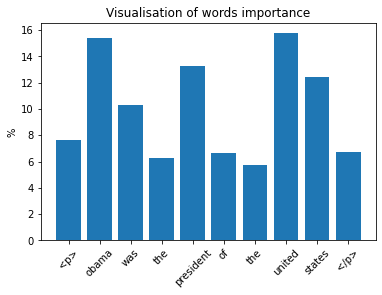

(tensor([[ 0.0075, -0.0586,  0.1304,  ...,  0.0588, -0.0313, -0.0125]],
        grad_fn=<MaxBackward0>),
 array([[0, 7, 7, ..., 4, 4, 8]], dtype=int64))

In [214]:
infersent.visualize('obama was the president of the united states', tokenize=True)

In [254]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

def infersent_doc_retrieval(query):
    query_vec = infersent.encode([query])[0]
    similarity = []
    counter = 0
    for idx, row in df.iterrows():
        sim = cosine(query_vec, infersent_embeddings_loaded[counter])
        similarity.append((idx, sim))
        counter += 1
    return sorted(similarity, key=lambda x: x[1], reverse=True)[:10]

In [255]:
test_query = "What does polytechnic mean in Singapore?"
infersent_mostsimilar = infersent_doc_retrieval(test_query)

for i in infersent_mostsimilar:
    print(f"Index / Score: {i}")
    print(f"Context: {df.loc[i[0],'context']}")
    print('------------')

Index / Score: (7595, 0.28422055)
Context: Politechnika (translated as a "technical university" or "university of technology") is a main kind of technical university name in Poland. There are some biggest Polytechnic in Poland:
------------
Index / Score: (7520, 0.26332223)
Context: In Croatia there are many polytechnic institutes and colleges that offer a polytechnic education. The law about polytechnic education in Croatia was passed in 1997.
------------
Index / Score: (7507, 0.23744357)
Context: Hogeschool is used in Belgium and in the Netherlands. The hogeschool has many similarities to the Fachhochschule in the German language areas and to the ammattikorkeakoulu in Finland.
------------
Index / Score: (7489, 0.22272334)
Context: While the terms "institute of technology" and "polytechnic" are synonymous, the preference concerning which one is the preferred term varies from country to country.[citation needed]
------------
Index / Score: (7529, 0.21479979)
Context: Universities of 

## Method 7: InferSent + K-Means Clustering

In [237]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from kneed import KneeLocator

In [238]:
kmeans_kwargs = {"init": "random", "n_init": 10, "max_iter": 300, "random_state": 42}

In [240]:
# A list holds the SSE values for each k
sse = []
for k in range(1, 11):
    print(f"Iteration: {k}")
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(embeddings)
    sse.append(kmeans.inertia_)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10


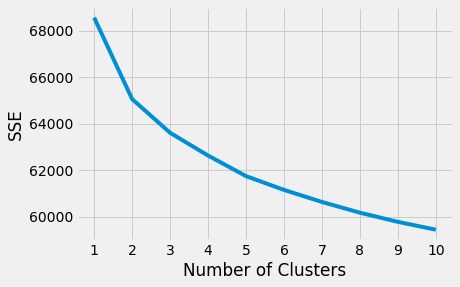

In [241]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [242]:
kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

In [243]:
# To do: label docs to cluster, match new query to cluster and retrieve docs in that cluster

## ^ Not sure if this method makes sense? Like if we alr have the embeddings for each sentence, is there any benefit of clustering over direct cosine similarity?

## Method 8: Topic Modelling (LDA)
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [272]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [273]:
sentences = list(df['extractive_summarized_3_sent'])

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(sentences))

print(data_words[:1])

[['born', 'raised', 'houston', 'texas', 'performed', 'various', 'singing', 'dancing', 'competition', 'child', 'rose', 'fame', 'late', 'lead', 'singer', 'girl', 'group', 'destiny', 'child', 'hiatus', 'saw', 'release', 'beyonce', 'debut', 'album', 'dangerously', 'love', 'established', 'solo', 'artist', 'worldwide', 'earned', 'five', 'grammy', 'award', 'featured', 'billboard', 'hot', 'number', 'one', 'single', 'crazy', 'love', 'baby', 'boy', 'beyonce', 'giselle', 'knowles', 'carter', 'bi', 'jansei', 'bee', 'yon', 'say', 'born', 'september', 'american', 'singer', 'songwriter', 'record', 'producer', 'actress']]


In [274]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['born', 'raised', 'houston', 'texas', 'performed', 'various', 'singing', 'dancing', 'competition', 'child', 'rose', 'fame', 'late', 'lead', 'singer', 'girl', 'group', 'destiny_child', 'hiatus', 'saw', 'release', 'beyonce', 'debut_album', 'dangerously', 'love', 'established', 'solo_artist', 'worldwide', 'earned', 'five', 'grammy_award', 'featured', 'billboard_hot', 'number', 'one', 'single', 'crazy', 'love', 'baby', 'boy', 'beyonce', 'giselle', 'knowles', 'carter', 'bi', 'jansei', 'bee', 'yon', 'say', 'born', 'september', 'american', 'singer_songwriter', 'record', 'producer', 'actress']


In [275]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

In [276]:
# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

In [277]:
print(data_words_bigrams[:1])

[['born', 'raised', 'houston', 'texas', 'performed', 'various', 'singing', 'dancing', 'competition', 'child', 'rose', 'fame', 'late', 'lead', 'singer', 'girl', 'group', 'destiny_child', 'hiatus', 'saw', 'release', 'beyonce', 'debut_album', 'dangerously', 'love', 'established', 'solo_artist', 'worldwide', 'earned', 'five', 'grammy_award', 'featured', 'billboard_hot', 'number', 'one', 'single', 'crazy', 'love', 'baby', 'boy', 'beyonce', 'giselle', 'knowles', 'carter', 'bi', 'jansei', 'bee', 'yon', 'say', 'born', 'september', 'american', 'singer_songwriter', 'record', 'producer', 'actress']]


In [279]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)

# Create Corpus
texts = data_words_bigrams

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1), (51, 1), (52, 1)]]


### Building LDA Mallet Model

In [303]:
import os
os.environ.update({'MALLET_HOME':'C:/Users/User/Documents/GitHub/tmproj/document_retrieval/lda_mallet/mallet-2.0.8/'})

mallet_path = 'C:/Users/User/Documents/GitHub/tmproj/document_retrieval/lda_mallet/mallet-2.0.8/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

In [304]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(12,
  [('country', 0.015310355230409533),
   ('government', 0.01309802146969354),
   ('nation', 0.01241923724765568),
   ('political', 0.01241923724765568),
   ('soviet', 0.008824194886492194),
   ('international', 0.008346531915428513),
   ('republic', 0.008069990195339015),
   ('union', 0.007164944565955201),
   ('movement', 0.007014103627724565),
   ('united', 0.0069135430022374735)]),
 (13,
  [('war', 0.034346614993338985),
   ('force', 0.023252997456703402),
   ('army', 0.019425941625287636),
   ('british', 0.01724597311372169),
   ('general', 0.01332202979290299),
   ('military', 0.013152476686447862),
   ('french', 0.011311614387792176),
   ('battle', 0.0104396269831658),
   ('operation', 0.009325420855032095),
   ('britain', 0.008719874046263777)]),
 (2,
  [('language', 0.03676450170771666),
   ('part', 0.028961763807513953),
   ('island', 0.022408574681365062),
   ('region', 0.021853219670674478),
   ('german', 0.01832671535278927),
   ('european', 0.013994946269402715),
   

NameError: name 'data_lemmatized' is not defined

### Finding the Optimal Number of Topics

In [ ]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[TO FILL IN LATER]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

### Finding the dominant topic in each sentence

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

### Topic distribution across documents

In [ ]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics